# Segmenting and Clustering Neighborhoods in Vancouver City - Food

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from urllib.request import urlopen
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# website scraping libraries and packages in Python from BeautifulSoup 
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup as bsoup

# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Libraries imported.


In [2]:
# Vancouver neighborhoods
van_neighborhoods = ['Arbutus Ridge', 'Cedar Cottage', 'Champlain Heights', 'Chinatown', 'Coal Harbour', 'Collingwood',
                     'Commercial Drive', 'Creekside', 'Downtown', 'Downtown Eastside', 'Dunbar-Southlands', 'Fairview',
                     'False Creek North', 'False Creek South', 'Gastown', 'Grandview-Woodland', 'Granville Island',
                     'Hastings-Sunrise', 'Hastings Crossing', 'Hastings East', 'Kensington-Cedar Cottage', 'Kerrisdale',
                     'Killarney', 'Kitsilano', 'Knight', 'Langara', 'Little Mountain', 'Main', 'Marpole', 'Mole Hill',
                     'Mount Pleasant', 'Musqueam', 'Oakridge', 'Quilchena', 'Renfrew-Collingwood', 'Riley Park', 'Southwest Marine',
                     'Sunrise', 'Sunset', 'Victoria-Fraserview', 'West Broadway', 'West End', 'West Point Grey', 'Yaletown']

In [3]:
df_van = pd.DataFrame(van_neighborhoods)
df_van.columns = ['Neighborhood']
df_van.head()

,Neighborhood
0,Arbutus Ridge
1,Cedar Cottage
2,Champlain Heights
3,Chinatown
4,Coal Harbour


In [4]:
#create a function to handle TimeOuts from Geocoder
from geopy.exc import GeocoderTimedOut
locator = Nominatim(user_agent = "bostonagent")

def do_geocode(address):
    try:
        return locator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [5]:
neighborhoods = df_van.values.tolist()

latitude = []
longitude = []
for neighborhood in neighborhoods:
    print('-', end='')
    coord = do_geocode('{}, Vancouver'.format(neighborhood))
    
    #check to make sure all latitude and longitude values are present in the Nominatim API
    #handles the case where Nominatim returns a 'None' object because the neighborhood does not exist in their API
    
    if (coord == None):
        latitude.append('0')
        longitude.append('0')
    else:
        latitude.append(coord.latitude)
        longitude.append(coord.longitude)

#add coordinates columns to dataframe
df_van['Latitude'] = latitude
df_van['Longitude'] = longitude

df_van.head()

--------------------------------------------

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.240968,-123.167001
1,Cedar Cottage,49.251622,-123.064548
2,Champlain Heights,49.215266,-123.030915
3,Chinatown,49.279981,-123.104089
4,Coal Harbour,49.290375,-123.129281


In [6]:
address = 'Vancouver City'

#Get lat/long values for Boston and print them
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Vancouver are {latitude:.4f}, {longitude:.4f}.')

The geograpical coordinates of Vancouver are 49.2609, -123.1140.


In [8]:
CLIENT_ID = 'FSZVPNI2CAF03EVZTVUIYVPDYLDSIASHNT110VQOR1V2PESA' # your Foursquare ID
CLIENT_SECRET = 'NF1LY5MQWY4LGRES0QB3JJZWKUINPUCQ42WWPJQXHUHYKPRA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
# Explore Neighborhoods in Brooklyn

LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Create a new dataframe called brooklyn_venues
van_venues = getNearbyVenues(names=df_van['Neighborhood'],
                                   latitudes=df_van['Latitude'],
                                   longitudes=df_van['Longitude'])
print('\nDone!')

............................................
Done!


In [10]:
#DataFrame of the most frequent venues in Vancouver

#group by category
mostpop= van_venues.groupby('Venue Category').count()

#sort values in descending order
mostpop = mostpop.sort_values(by = 'Neighborhood', ascending = False)

#select only the top 10 venues
mostpop= mostpop[0:10]

#reset index for visualization
mostpop.reset_index(inplace=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


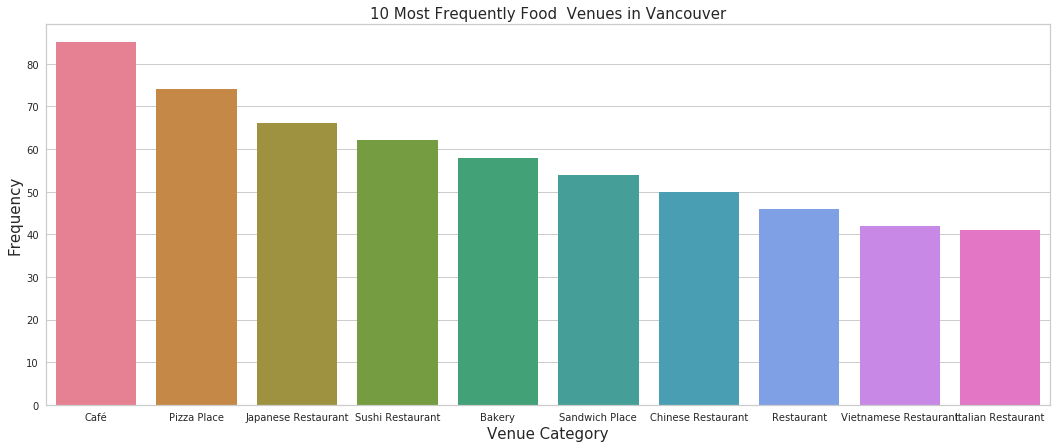

In [11]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Neighborhood",  palette="husl",saturation = 0.75, data=mostpop)
sns.set_context("paper")
s.set_xticklabels(s.get_xticklabels())
plt.title('10 Most Frequently Food  Venues in Vancouver', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()
fig.savefig('10most-common-food-ven-Vancouver.png', dpi=300)

In [12]:
# Checking the size of the resulting dataframe
print(van_venues.shape)
van_venues.head()

(1225, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.240968,-123.167001,Butter Baked Goods,49.242209,-123.170381,Bakery
1,Arbutus Ridge,49.240968,-123.167001,East Is East,49.238004,-123.171126,Indian Restaurant
2,Cedar Cottage,49.251622,-123.064548,Commercial Street Cafe,49.252539,-123.068178,Café
3,Cedar Cottage,49.251622,-123.064548,Casa Verde Portuguese Restaurant,49.253189,-123.067848,Portuguese Restaurant
4,Cedar Cottage,49.251622,-123.064548,Chance Cafe,49.253993,-123.067833,Café


In [13]:
# Checking how many veneus were returned for each neighborhood
van_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbutus Ridge,2,2,2,2,2,2
Cedar Cottage,4,4,4,4,4,4
Champlain Heights,3,3,3,3,3,3
Chinatown,100,100,100,100,100,100
Coal Harbour,78,78,78,78,78,78


In [14]:
# Analyze Each Neighborhood

# one hot encoding
van_onehot = pd.get_dummies(van_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
van_onehot['Neighborhood'] = van_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [van_onehot.columns[-1]] + list(van_onehot.columns[:-1])
van_onehot = van_onehot[fixed_columns]

print(van_onehot.shape)
van_onehot.head()

(1225, 90)


,Neighborhood,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arbutus Ridge,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cedar Cottage,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cedar Cottage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cedar Cottage,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
van_grouped = van_onehot.groupby('Neighborhood').mean().reset_index()

van_grouped.head()

(44, 90)


,Neighborhood,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Arbutus Ridge,0.000000,0.000000,0.0,0.00,0.0,0.500000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.500000,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000
1,Cedar Cottage,0.000000,0.000000,0.0,0.00,0.0,0.250000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.00,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000
2,Champlain Heights,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.333333,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.00,0.666667,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000
3,Chinatown,0.030000,0.020000,0.0,0.01,0.0,0.050000,0.01,0.0,0.020000,0.010000,0.0,0.0,0.090000,0.0,0.0,0.01,0.080000,0.000000,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.000000,0.0,0.01,0.010000,0.0,0.0,0.0,0.0,0.010000,0.02,0.01,0.050000,0.02,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.01,0.01,0.0,0.010000,0.0,0.020000,0.000000,0.0,0.0,0.0,0.010000,0.0,0.040000,0.000000,0.0,0.01,0.02,0.030000,0.0,0.01,0.070000,0.01,0.00,0.000000,0.050000,0.0,0.000000,0.060000,0.020000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.040000,0.000000,0.02,0.0,0.01,0.01,0.01,0.030000,0.000000
4,Coal Harbour,0.012821,0.012821,0.0,0.00,0.0,0.012821,0.00,0.0,0.038462,0.012821,0.0,0.0,0.051282,0.0,0.0,0.00,0.038462,0.012821,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.012821,0.0,0.00,0.012821,0.0,0.0,0.0,0.0,

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = van_grouped['Neighborhood']

for ind in np.arange(van_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Indian Restaurant,Bakery,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
1,Cedar Cottage,Café,Portuguese Restaurant,Bakery,Food Court,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
2,Champlain Heights,Pizza Place,Café,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
3,Chinatown,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Bakery,Gastropub,Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant
4,Coal Harbour,Japanese Restaurant,Ramen Restaurant,Korean Restaurant,Restaurant,Seafood Restaurant,Café,Sushi Restaurant,Noodle House,Breakfast Spot,Chinese Restaurant


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


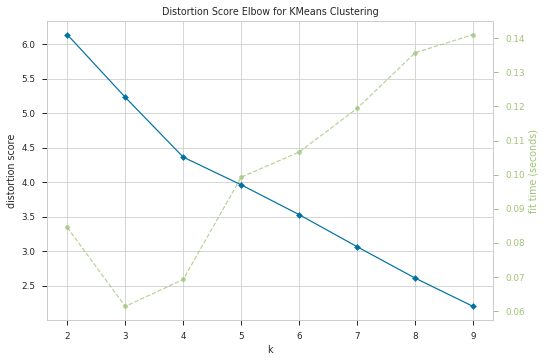

In [21]:
#elbow method to determine best cluster numbers
model = KMeans()
van_grouped_clustering = van_grouped.drop('Neighborhood', 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(van_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()

In [22]:
# The visualization generated by Yellowbrick indicated that a k value of 5 would produce the most effective clusters for our data
# We will be running our K-means clustering algorithm on our weighted van_grouped DataFrame with this k value after removing the Neighborhood name from the DataFrame
# After we generate our cluster labels, we will add them to our Top 10 Venues DataFrame. Again, this will make it easier for us to understand how k-means clustered our neighborhoods in the future

kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(van_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 2, 4, 4, 4, 4, 2, 4, 4], dtype=int32)

In [23]:
# add clustering labels

#uncomment this line if running block again
#neighborhoods_venues_sorted.drop(columns =['Cluster Labels'], axis = 1, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

van_merged = df_van

# merge van_grouped with df to add latitude/longitude for each neighborhood
van_merged = van_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

van_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,49.240968,-123.167001,0,Indian Restaurant,Bakery,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
1,Cedar Cottage,49.251622,-123.064548,4,Café,Portuguese Restaurant,Bakery,Food Court,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
2,Champlain Heights,49.215266,-123.030915,2,Pizza Place,Café,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
3,Chinatown,49.279981,-123.104089,4,Café,Chinese Restaurant,Pizza Place,Sandwich Place,Bakery,Gastropub,Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant
4,Coal Harbour,49.290375,-123.129281,4,Japanese Restaurant,Ramen Restaurant,Korean Restaurant,Restaurant,Seafood Restaurant,Café,Sushi Restaurant,Noodle House,Breakfast Spot,Chinese Restaurant
5,Collingwood,49.238366,-123.031678,4,Asian Restaurant,Pizza Place,Bakery,Sandwich Place,Thai Restaurant,BBQ Joint,Sushi Restaurant,Café,Wings Joint,Dumpling Restaurant
6,Commercial Drive,49.266874,-123.069679,4,Pizza Place,Sushi Restaurant,Deli / Bodega,Café,Italian Restaurant,Sandwich Place,Burger Joint,Ethiopian Restaurant,Falafel Restaurant,Indian Restaurant
7,Creekside,49.211151,-123.033780,2,Pizza Place,Café,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
8,Downtown,49.283393,-123.117456,4,Restaurant,Food Truck,Café,Sandwich Place,Seafood Restaurant,Pizza Place,Steakhouse,Vietnamese Restaurant,New American Restaurant,Burger Joint
9,Downtown Eastside,49.282399,-123.099458,4,Café,Diner,Chinese Restaurant,Noodle House,Seafood Restaurant,Asian Restaurant,Pizza Place,Sandwich Place,Gastropub,German Restaurant


In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(van_merged['Latitude'], 
                                  van_merged['Longitude'], 
                                  van_merged['Neighborhood'], 
                                  van_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
# Cluster 1
van_c1 = van_merged.loc[van_merged['Cluster Labels'] == 0,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c1.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Bakery,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
26,Little Mountain,Bakery,Seafood Restaurant,Food Court,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
33,Quilchena,Seafood Restaurant,Wings Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
38,Sunset,South Indian Restaurant,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
39,Victoria-Fraserview,Sandwich Place,Pizza Place,Wings Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [28]:
# Cluster 2
van_c2 = van_merged.loc[van_merged['Cluster Labels'] == 1,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c2.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Hastings Crossing,Chinese Restaurant,Seafood Restaurant,Burger Joint,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant
19,Hastings East,Chinese Restaurant,Seafood Restaurant,Burger Joint,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant
22,Killarney,Snack Place,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
37,Sunrise,Chinese Restaurant,Seafood Restaurant,Burger Joint,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [29]:
# Cluster 3
van_c3 = van_merged.loc[van_merged['Cluster Labels'] == 2,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c3.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Champlain Heights,Café,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
7,Creekside,Café,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant


In [30]:
# Cluster 4
van_c4 = van_merged.loc[van_merged['Cluster Labels'] == 3,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c4.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Langara,Indian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [31]:
# Cluster 5
van_c5 = van_merged.loc[van_merged['Cluster Labels'] == 4,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c5.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cedar Cottage,Portuguese Restaurant,Bakery,Food Court,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
3,Chinatown,Chinese Restaurant,Pizza Place,Sandwich Place,Bakery,Gastropub,Restaurant,Mexican Restaurant,Sushi Restaurant,Vietnamese Restaurant
4,Coal Harbour,Ramen Restaurant,Korean Restaurant,Restaurant,Seafood Restaurant,Café,Sushi Restaurant,Noodle House,Breakfast Spot,Chinese Restaurant
5,Collingwood,Pizza Place,Bakery,Sandwich Place,Thai Restaurant,BBQ Joint,Sushi Restaurant,Café,Wings Joint,Dumpling Restaurant
6,Commercial Drive,Sushi Restaurant,Deli / Bodega,Café,Italian Restaurant,Sandwich Place,Burger Joint,Ethiopian Restaurant,Falafel Restaurant,Indian Restaurant


In [32]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

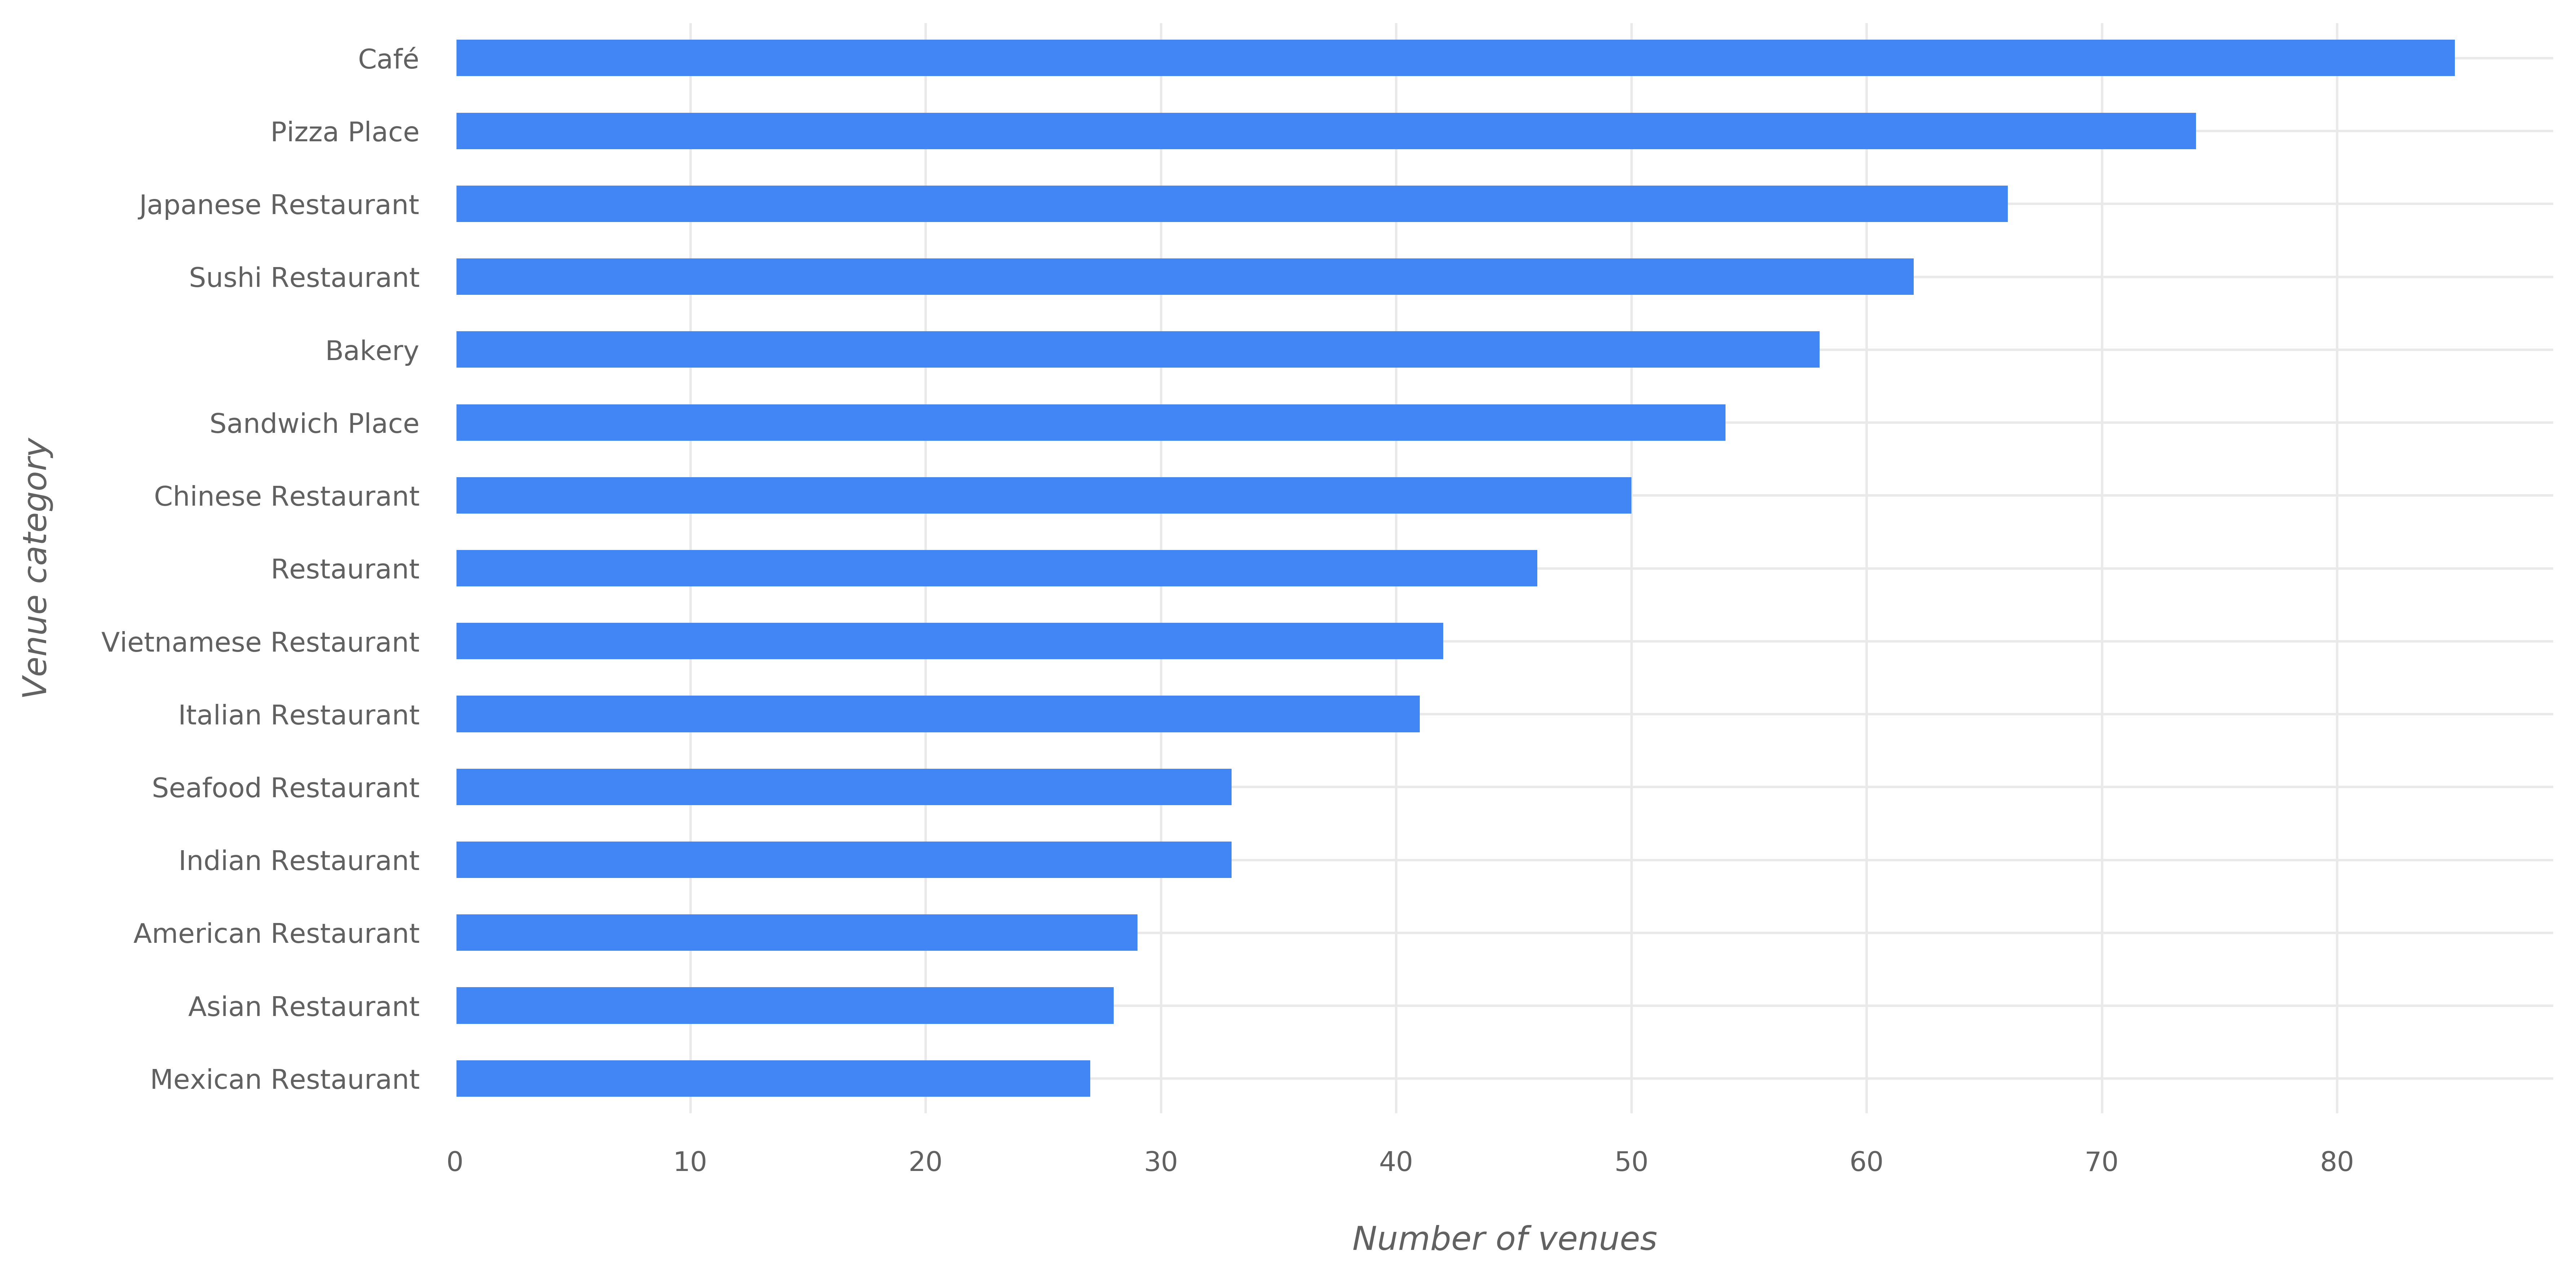

In [36]:
# Most Common Food Venue Categories in Vancouver

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_top_vc = van_venues['Venue Category'].value_counts(normalize=False)
ax = van_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-food-Vancouver.png', dpi=300)

44 neighborhoods in Vancouver


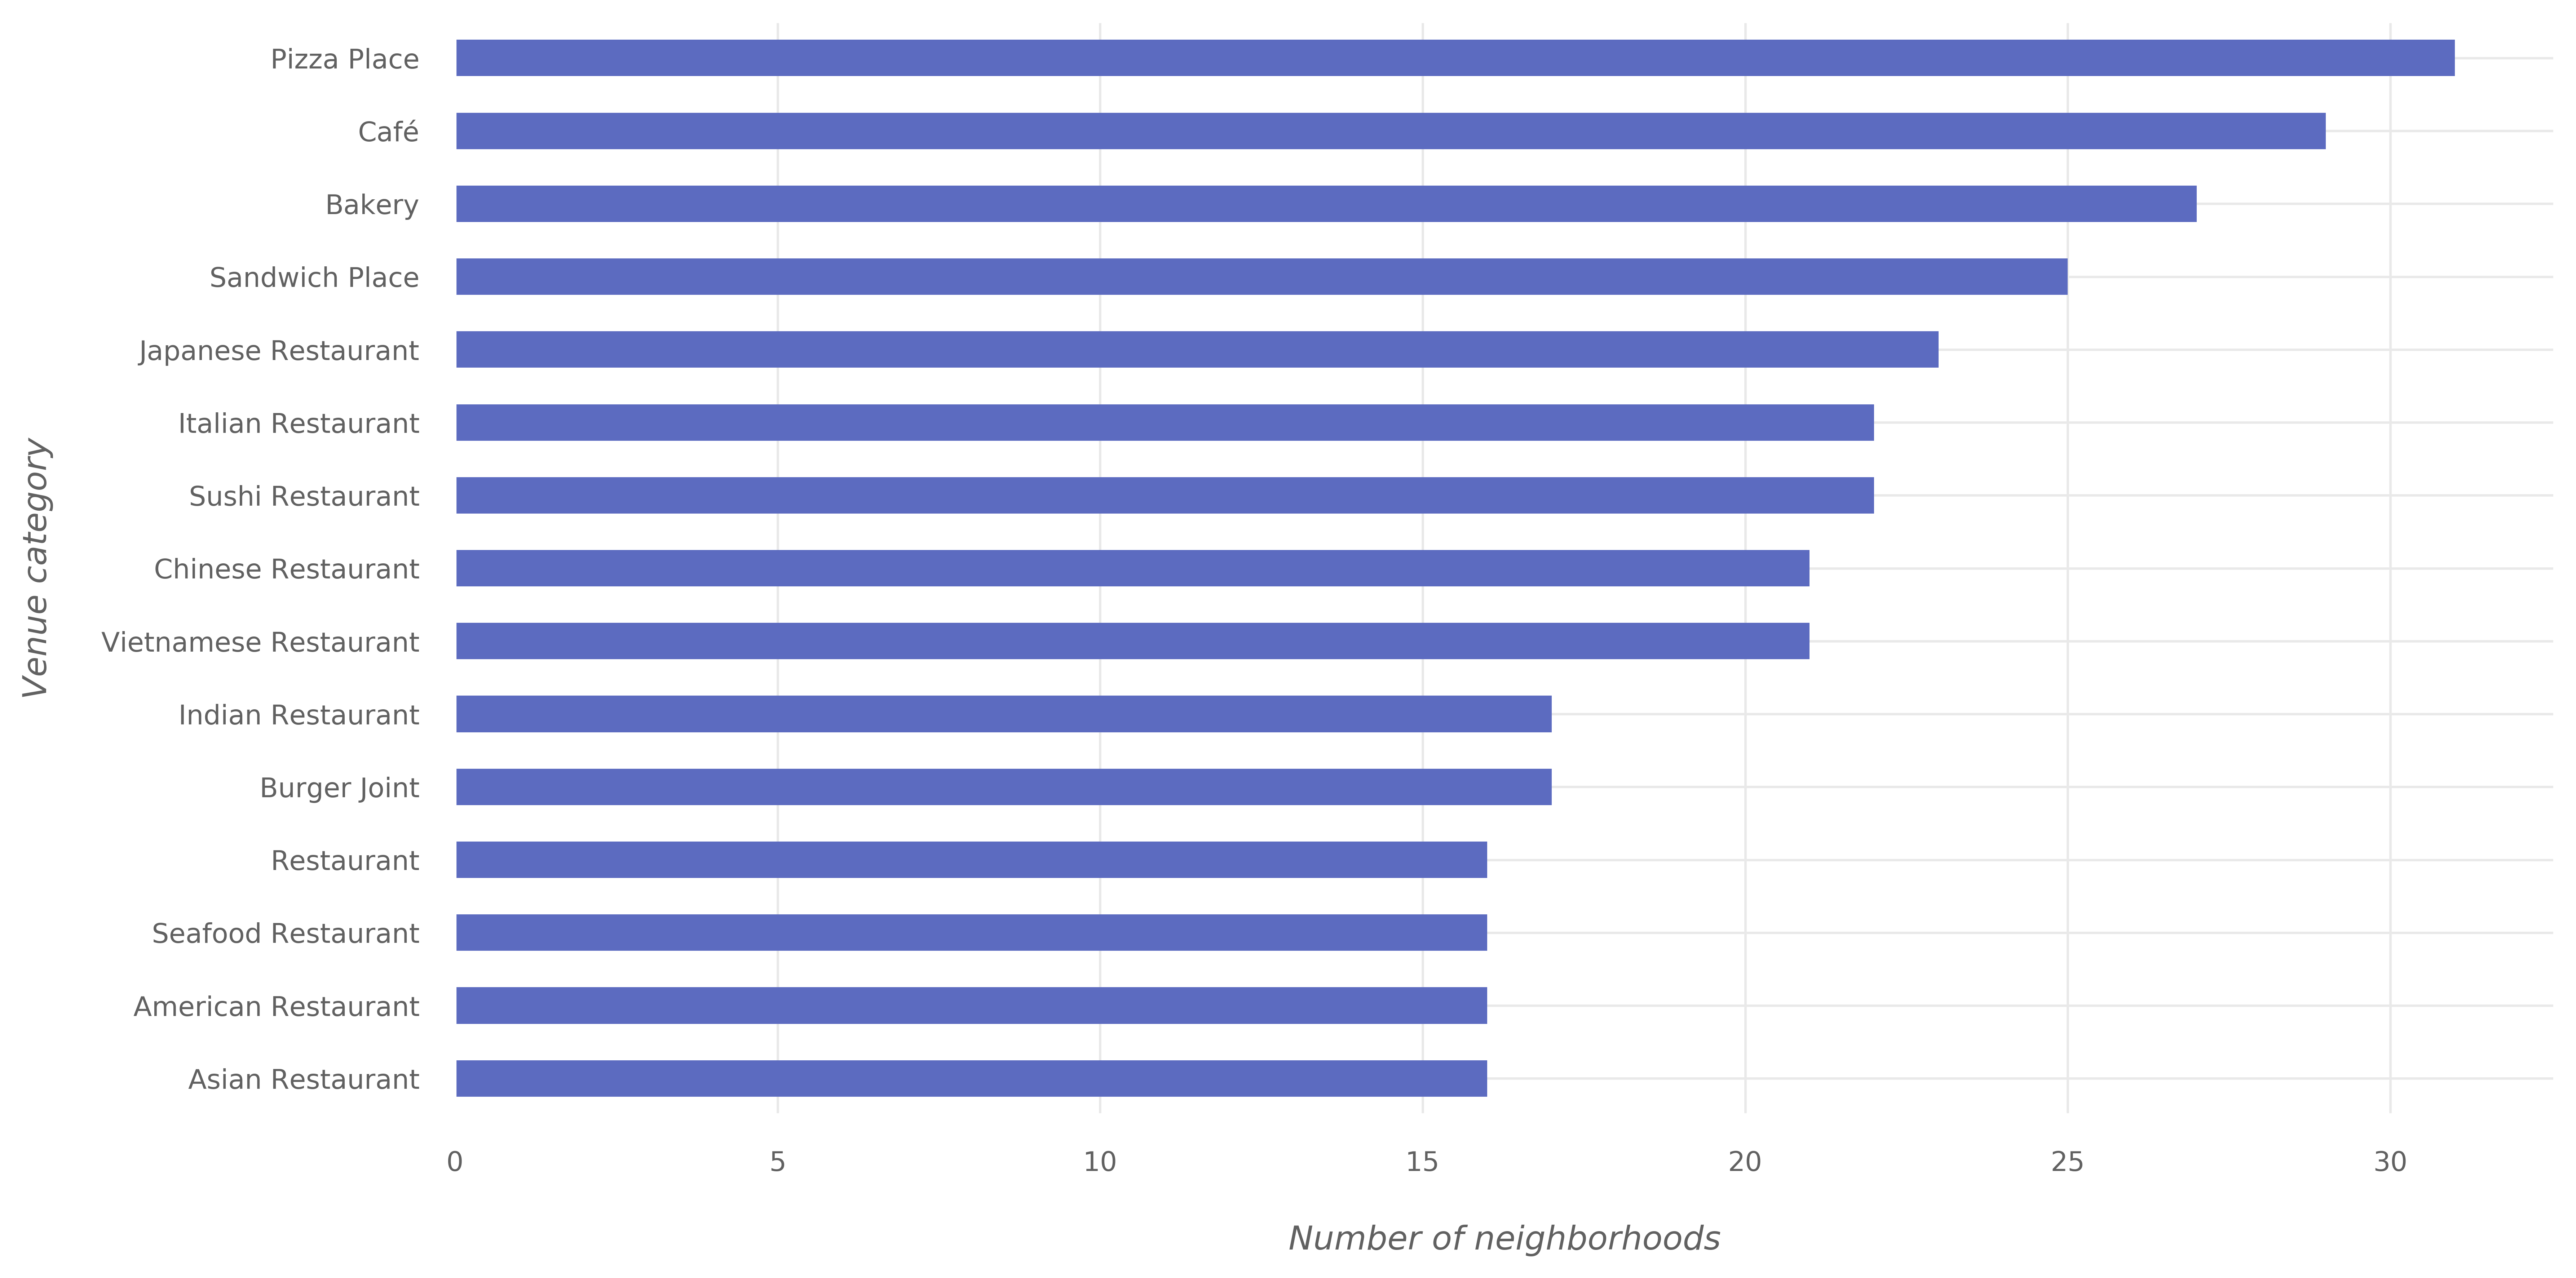

In [37]:
# Which Food Venue Exist More in Vancouver Neighborhoods?

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_g = van_onehot.groupby('Neighborhood').max().reset_index()
van_p = van_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print(f"{van_g.shape[0]} neighborhoods in Vancouver")
ax = van_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-food-Vancouver.png', dpi=300)

In [35]:
# Rare Categories in Vancouver

van_bot_vc = van_venues['Venue Category'].value_counts(normalize=False)
van_bot_vc = van_bot_vc.tail(15).to_frame('Count')
van_bot_vc.index.names = ['Venue Category']
van_bot_vc

,Count
Venue Category,
Dumpling Restaurant,2
Taiwanese Restaurant,2
Food Court,2
Filipino Restaurant,2
Cafeteria,1
Cajun / Creole Restaurant,1
Shabu-Shabu Restaurant,1
Soup Place,1
Eastern European Restaurant,1
